<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/convenience_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 利便性
- input:
    - convenience_store.csv
        - コンビニ店舗位置
    - supermarket.csv
        - スーパー店舗位置
    - train_station.csv
        - 最寄り駅の位置
- output:
    - convenience_score.csv
        - 買い物スコア
        - 駅スコア
        - 利便性スコア

In [1]:
!pip install -q japanize-matplotlib

     |████████████████████████████████| 4.1 MB 6.7 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

### 人口マスタ

In [5]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_pop_master.shape)

(3145, 6)


### コンビニ

In [6]:
df_convini_master = pd.read_csv(os.path.join(DIR_NAME, 'convenience_store.csv'))[['name', 'lat', 'lng']]
df_convini_master['施設分類'] = 'コンビニ'
df_convini_master = df_convini_master.rename(columns={'lat':'緯度', 'lng':'経度'})
print(df_convini_master.shape)

(6405, 4)


### スーパー

In [7]:
df_super_master = pd.read_csv(os.path.join(DIR_NAME, 'supermarket.csv'))[['name', 'lat', 'lng']]
df_super_master['施設分類'] = 'スーパー'
df_super_master = df_super_master.rename(columns={'lat':'緯度', 'lng':'経度'})
print(df_super_master.shape)

(2060, 4)


### 最寄駅

In [8]:
df_station_master = pd.read_csv(os.path.join(DIR_NAME, 'train_station.csv'))[['no', 'name', 'lat', 'lng']]
df_station_master = df_station_master.rename(columns={'no':'地域ID', 'name':'最寄駅'})
print(df_station_master.shape)

(3141, 4)


In [9]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

### スコア

In [10]:
%%time
# 0.5km以内の施設の数
df_pop_master['コンビニ(数)'] = get_value_of_nearest_facility(df_pop_master, df_convini_master, 'コンビニ', 'count', 0.5)
# 近い3件の距離の平均
df_pop_master['コンビニ(平均距離)'] = get_value_of_nearest_facility(df_pop_master, df_convini_master, 'コンビニ', 'mean', 3)
# 1km以内の施設の数
df_pop_master['スーパー(数)'] = get_value_of_nearest_facility(df_pop_master, df_super_master, 'スーパー', 'count', 1)

CPU times: user 18min 6s, sys: 3.17 s, total: 18min 9s
Wall time: 18min 34s


In [11]:
# 最寄駅からの距離
pop_master_len = len(df_pop_master)
df_pop_master = pd.merge(df_pop_master, df_station_master, on='地域ID', how='left')
assert len(df_pop_master) == pop_master_len

df_pop_master['最寄駅(距離)'] = df_pop_master.apply(lambda x: get_distance(x['緯度'], x['経度'], x['lat'], x['lng']), axis=1)
df_pop_master = df_pop_master.drop(columns=['lat', 'lng'])

In [12]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 11)


,地域ID,市区町村名,町名,町丁目,緯度,経度,コンビニ(数),コンビニ(平均距離),スーパー(数),最寄駅,最寄駅(距離)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,72,0.039658,13,東京駅,0.054248
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,58,0.101209,10,東京駅,0.315152
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,46,0.101844,9,有楽町駅,0.228117
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,36,0.069556,7,大手町駅,0.317383
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,43,0.128402,15,大手町駅,0.488932


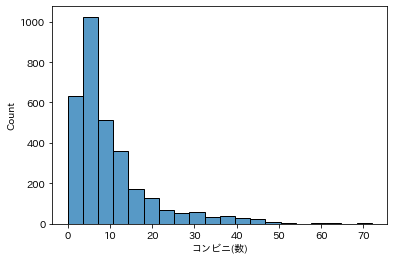

In [13]:
sns.histplot(df_pop_master['コンビニ(数)'], bins=20)
plt.show()

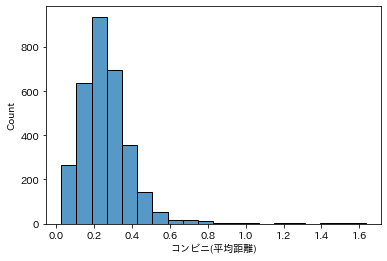

In [14]:
sns.histplot(df_pop_master['コンビニ(平均距離)'], bins=20)
plt.show()

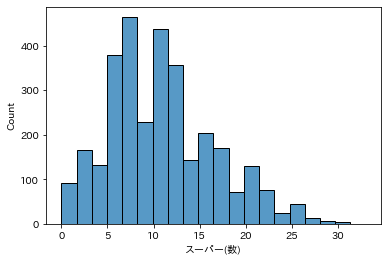

In [15]:
sns.histplot(df_pop_master['スーパー(数)'], bins=20)
plt.show()

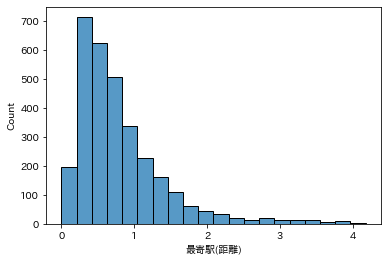

In [16]:
sns.histplot(df_pop_master['最寄駅(距離)'], bins=20)
plt.show()

In [17]:
import numpy as np
from scipy.stats import norm

def rank_score(sr_data):
    rank = sr_data.rank()
    count = rank.max() 
    x = (rank + 1)/(count + 1)
    max_val = 5
    y = norm.ppf(x, loc=0.5, scale=0.14)*max_val
    return np.clip(y, 0, max_val)

In [18]:
df_pop_master['コンビニ(数)レベル'] = rank_score(df_pop_master['コンビニ(数)'])
df_pop_master['コンビニ(平均距離)レベル'] = rank_score(df_pop_master['コンビニ(平均距離)']*(-1))
df_pop_master['スーパー(数)レベル'] = rank_score(df_pop_master['スーパー(数)'])

In [19]:
score_name_list = []
score_name = '買い物スコア'
score_name_list.append(score_name)

score_list = [
    df_pop_master['コンビニ(数)レベル'] * 0.5,
    df_pop_master['コンビニ(平均距離)レベル'] * 0.5,
    df_pop_master['スーパー(数)レベル'] * 1.0,
]
_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score).round(2)

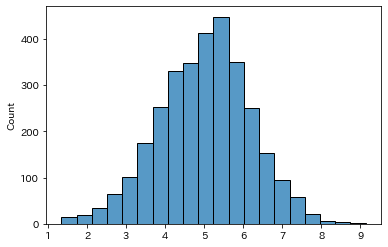

In [20]:
sns.histplot(_tmp_score, bins=20)
plt.show()

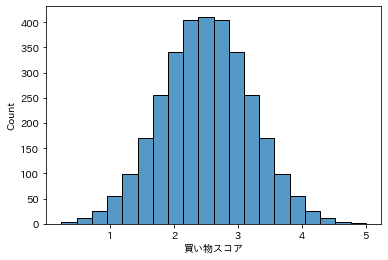

In [21]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [22]:
df_pop_master[score_name].describe()

count    3141.000000
mean        2.501557
std         0.698643
min         0.240000
25%         2.030000
50%         2.500000
75%         2.970000
max         5.000000
Name: 買い物スコア, dtype: float64

In [23]:
score_name = '駅スコア'
score_name_list.append(score_name)

df_pop_master[score_name] = rank_score(df_pop_master['最寄駅(距離)']*(-1)).round(2)

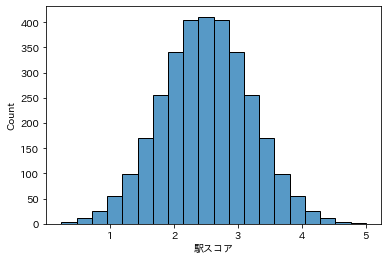

In [24]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [25]:
df_pop_master[score_name].describe()

count    3141.000000
mean        2.501557
std         0.698643
min         0.240000
25%         2.030000
50%         2.500000
75%         2.970000
max         5.000000
Name: 駅スコア, dtype: float64

In [26]:
score_name = '利便性スコア'
score_name_list.append(score_name)

score_list = [
    df_pop_master['買い物スコア'] * 1.0,
    df_pop_master['駅スコア'] * 1.0,
]
df_pop_master[score_name] = rank_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False)).round(2)

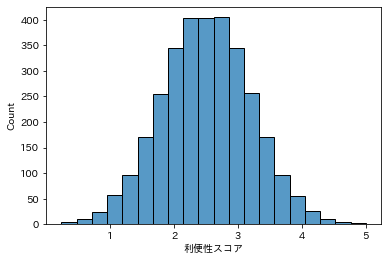

In [27]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [28]:
df_pop_master[score_name].describe()

count    3141.000000
mean        2.501649
std         0.698448
min         0.240000
25%         2.030000
50%         2.500000
75%         2.970000
max         5.000000
Name: 利便性スコア, dtype: float64

In [29]:
feature_list = ['コンビニ(数)', 'コンビニ(平均距離)', 'スーパー(数)', '最寄駅(距離)']

df_pop_master['コンビニ(平均距離)'] = df_pop_master['コンビニ(平均距離)'].round(3)
df_pop_master['最寄駅(距離)'] = df_pop_master['最寄駅(距離)'].round(3)

In [30]:
output_score_file = 'convenience_score.csv'

In [31]:
df_pop_master[
    ['地域ID'] + feature_list + score_name_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

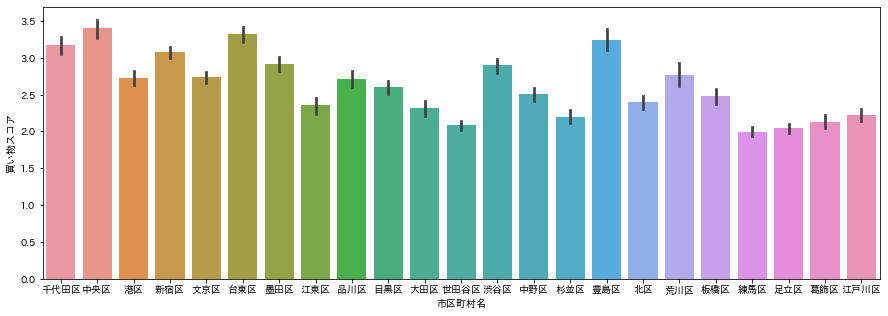

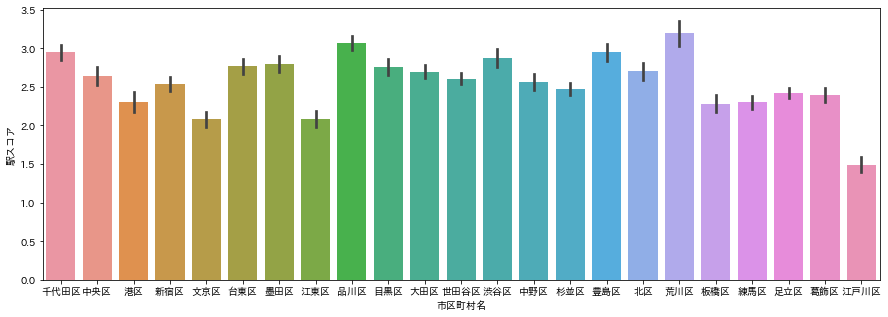

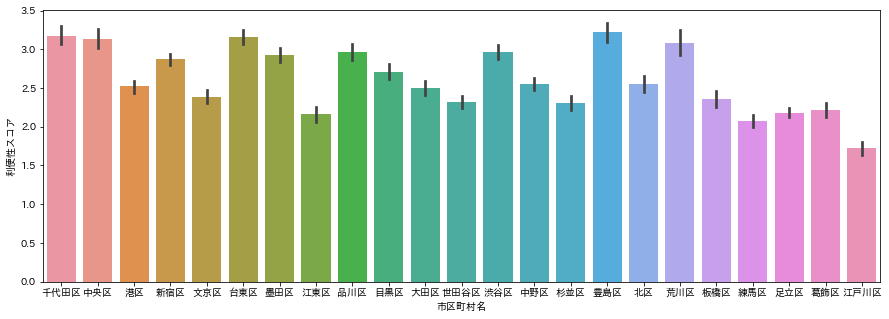

In [32]:
for score in score_name_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=score, data=df_pop_master)
    plt.show()

In [33]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目', '最寄駅'] + feature_list + score_name_list
].reset_index(drop=True)
print(df_level.shape)

(901, 11)


In [34]:
df_level.head(20)

,市区町村名,町名,町丁目,最寄駅,コンビニ(数),コンビニ(平均距離),スーパー(数),最寄駅(距離),買い物スコア,駅スコア,利便性スコア
0,豊島区,西池袋,西池袋１丁目,池袋駅,58,0.050,30,0.155,5.00,3.84,5.00
1,千代田区,丸の内,丸の内１丁目,東京駅,72,0.040,13,0.054,4.19,4.37,4.89
2,新宿区,歌舞伎町,歌舞伎町１丁目,西武新宿駅,47,0.052,26,0.151,4.61,3.86,4.76
3,千代田区,神田花岡町,神田花岡町,秋葉原駅,42,0.060,22,0.122,4.27,4.06,4.67
4,中央区,日本橋室町,日本橋室町３丁目,新日本橋駅,38,0.062,23,0.131,4.30,3.99,4.61
5,中央区,日本橋馬喰町,日本橋馬喰町１丁目,馬喰町駅,34,0.100,17,0.019,3.62,4.61,4.56
6,中央区,八丁堀,八丁堀４丁目,八丁堀駅,27,0.066,18,0.039,3.75,4.46,4.52
7,千代田区,神田佐久間町,神田佐久間町１丁目,秋葉原駅,40,0.042,21,0.157,4.37,3.83,4.49
8,豊島区,南池袋,南池袋１丁目,池袋駅,48,0.063,29,0.266,4.76,3.34,4.43
9,台東区,上野,上野６丁目,御徒町駅,51,0.049,22,0.208,4.49,3.59,4.41


In [35]:
df_level.tail(20)

,市区町村名,町名,町丁目,最寄駅,コンビニ(数),コンビニ(平均距離),スーパー(数),最寄駅(距離),買い物スコア,駅スコア,利便性スコア
881,板橋区,新河岸,新河岸２丁目,戸田公園駅,2,0.365,6,1.915,1.67,1.42,1.35
882,江戸川区,船堀,船堀３丁目,平井駅,8,0.091,3,3.432,2.23,0.86,1.35
883,江戸川区,宇喜田町,宇喜田町,葛西臨海公園駅,5,0.330,10,3.546,2.24,0.82,1.33
884,練馬区,立野町,立野町,武蔵関駅,2,0.439,2,1.339,1.25,1.77,1.30
885,江戸川区,下篠崎町,下篠崎町,本八幡駅,5,0.189,3,2.779,1.90,1.12,1.30
886,世田谷区,宇奈根,宇奈根１丁目,久地駅,2,0.414,2,1.561,1.27,1.59,1.21
887,世田谷区,岡本,岡本２丁目,二子玉川駅,2,0.482,1,1.346,1.10,1.76,1.21
888,大田区,京浜島,京浜島１丁目,昭和島駅,0,0.836,0,0.789,0.54,2.29,1.19
889,江戸川区,一之江町,一之江町,平井駅,4,0.297,8,3.766,2.10,0.72,1.18
890,江戸川区,西小松川町,西小松川町,平井駅,1,0.521,6,1.964,1.42,1.40,1.17
